In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore") 

### Read Pitcher data, analyze shape and NULL values

In [5]:
df_uncleaned = pd.read_csv('stats (11).csv')

print(f"DataFrame shape: {df_uncleaned.shape} \n")

print(f"Number of null values per column: \n\n{df_uncleaned.isnull().sum()}")

DataFrame shape: (446, 68) 

Number of null values per column: 

last_name                 0
 first_name               0
player_id                 0
year                      0
xwoba                     0
                       ... 
offspeed_avg_speed       58
offspeed_avg_spin        58
offspeed_avg_break_x     58
offspeed_avg_break_z     58
Unnamed: 67             446
Length: 68, dtype: int64


### Fill NaN values with 0

#### Cleaned dataframe will be called 'df'

In [6]:
# NaN values are for pitchers who don't throw a certain pitch type
df = df_uncleaned.fillna(0)

### Partition 'df' into relevant dataframes

In [7]:
# Create name df for later labeling and visual
naming_df = df[['last_name', ' first_name', 'player_id', 'year']]
print(naming_df.head())


# 12:67 = out_zone_percent : offspeed_avg_break_z
pitch_metric_df = df[df.columns[12:67]]




    last_name  first_name  player_id  year
0  Wainwright        Adam     425794  2022
1     Greinke        Zack     425844  2022
2   Verlander      Justin     434378  2022
3     Sanchez      Anibal     434671  2022
4      Jansen      Kenley     445276  2022


### Pitch Metric Kernel Density Estimators

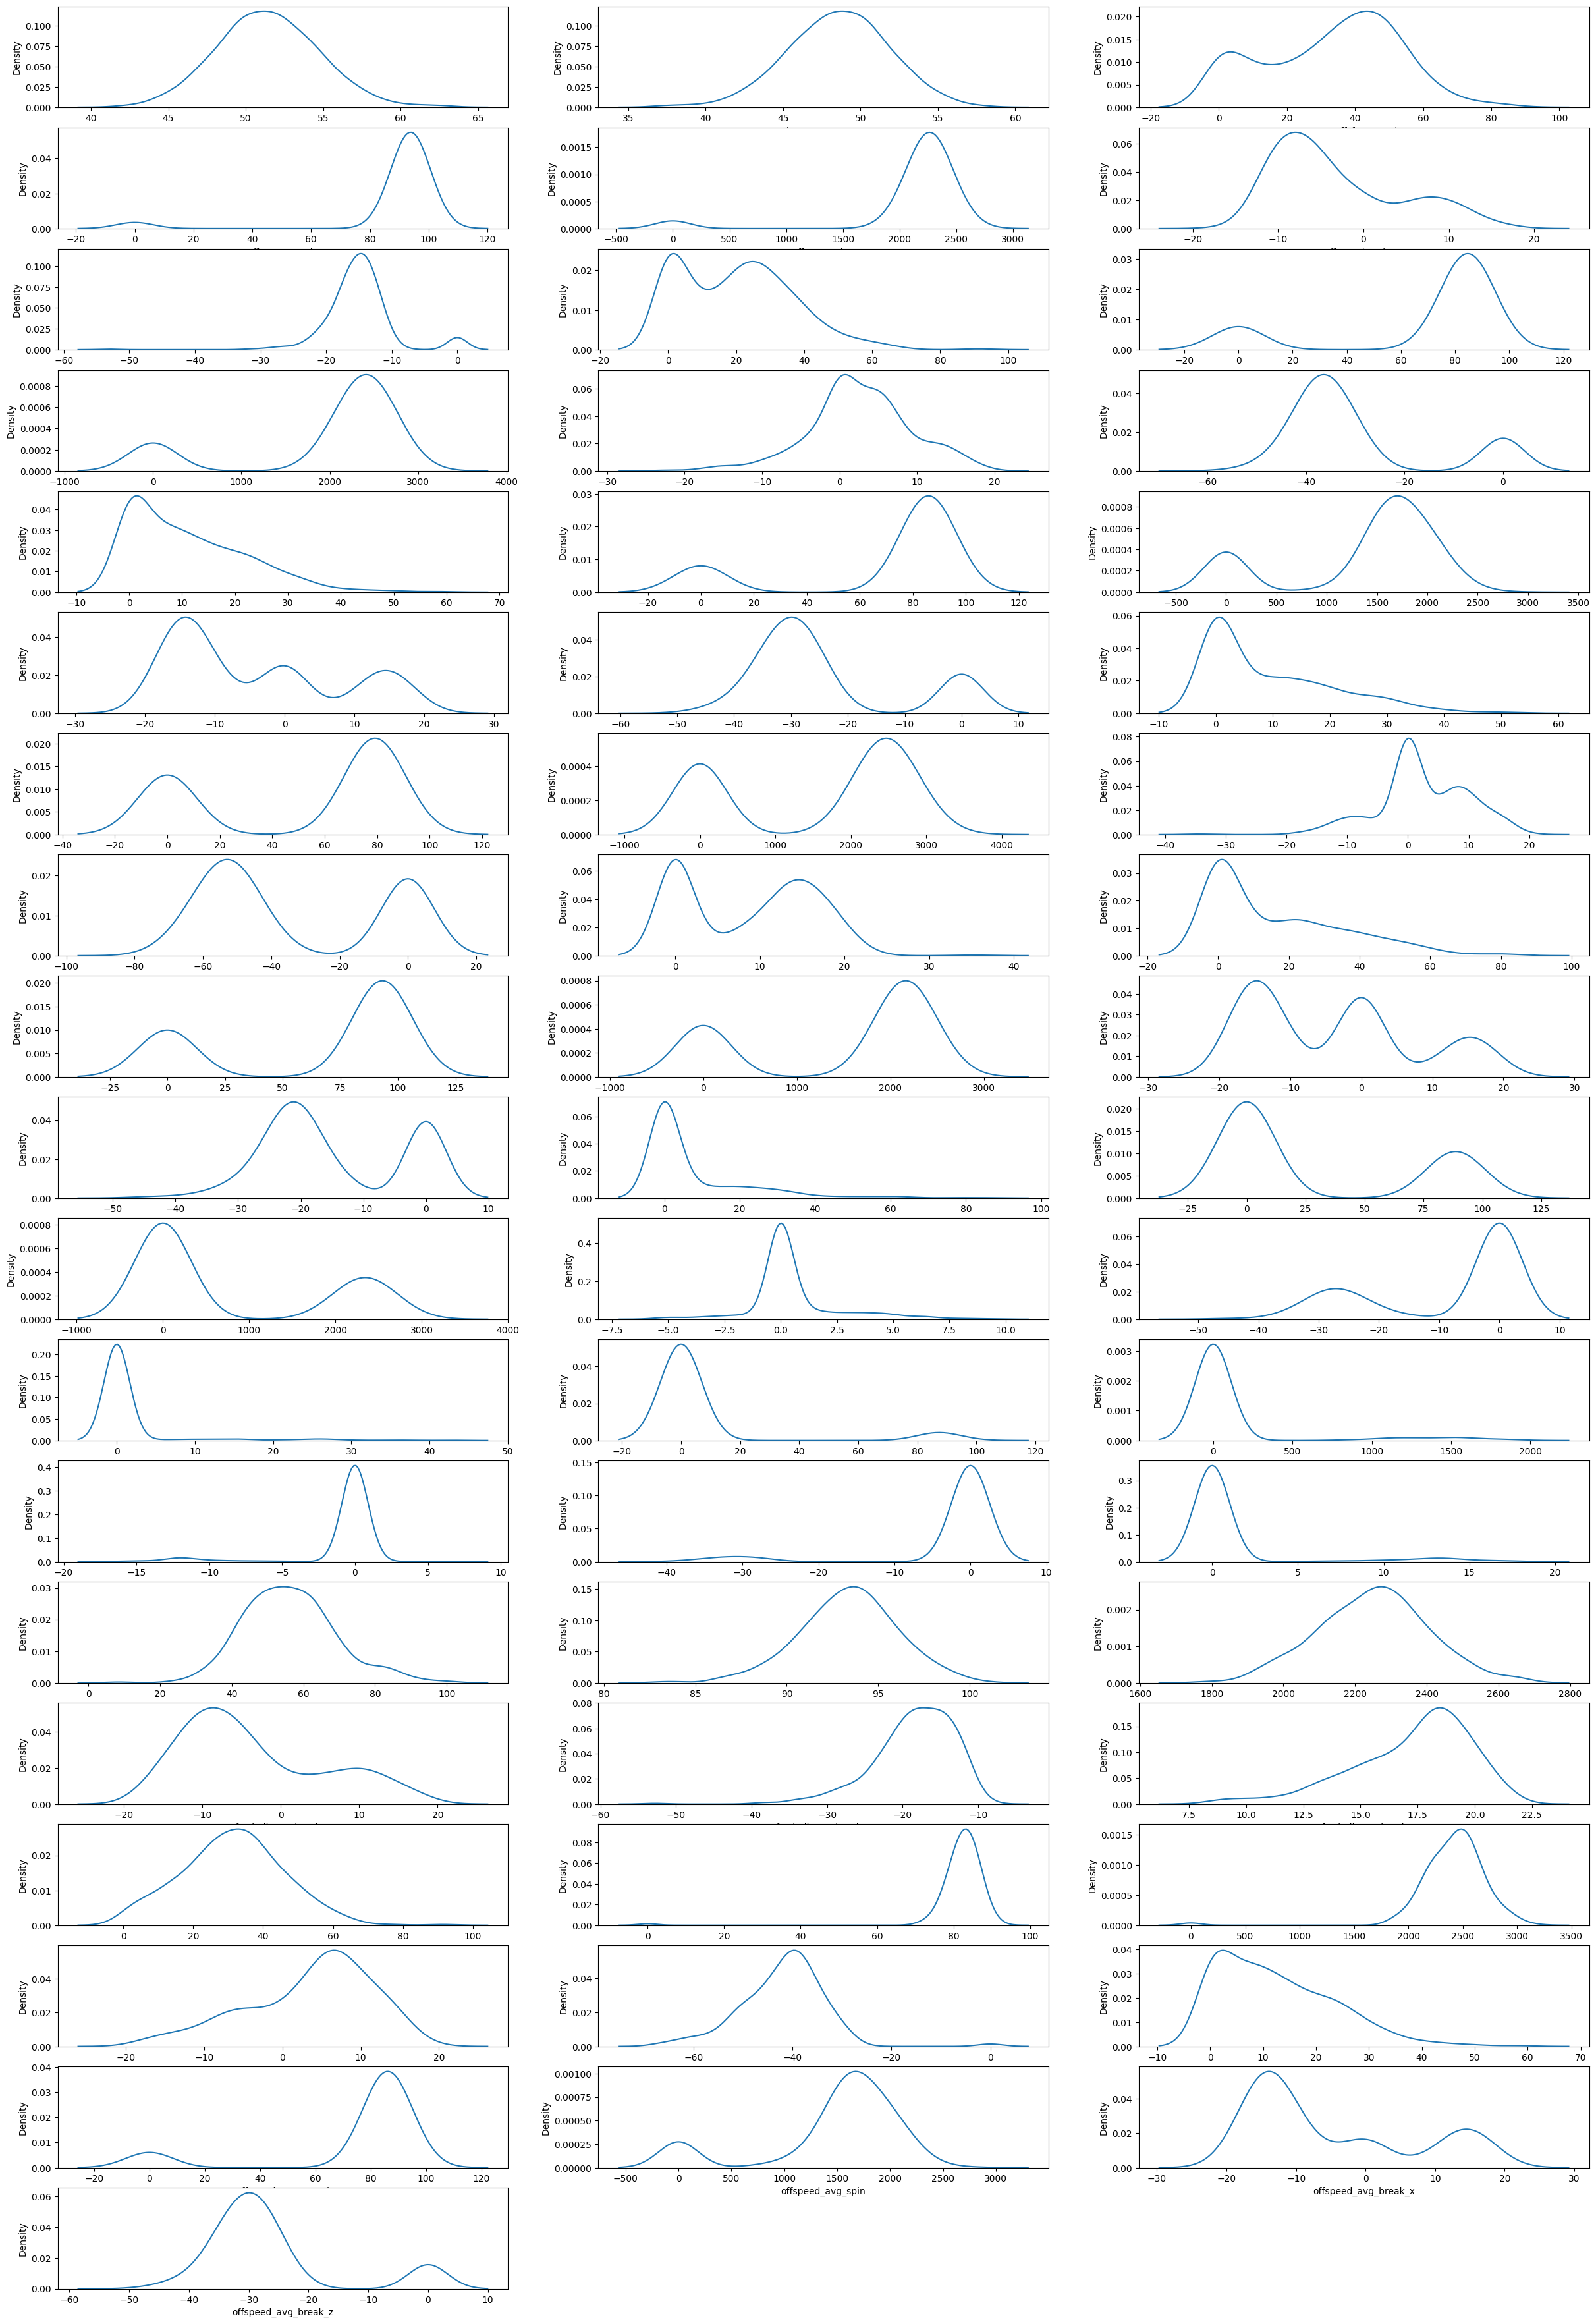

In [8]:
plt.figure(figsize=(30,45))
for i, col in enumerate(pitch_metric_df.columns):
    if pitch_metric_df[col].dtype != 'object':
        ax = plt.subplot(19,3, i+1)
        sns.kdeplot(pitch_metric_df[col], ax=ax) # kernel density estimation plot
        plt.xlabel(col)

plt.show()

#### The range of values in predictors means scaling could be necessary. 

Scaling pitch_outcome_df

In [13]:
# Scaling the pitch_metric DataFrame
scalar=StandardScaler()
scaled_metric = scalar.fit_transform(pitch_metric_df)

# PCA for scaled_metric pca_metric
pca_metric = PCA(n_components = 2)
pcs_metric = pca_metric.fit_transform(scaled_metric) # PrincipalComponentS
pca_df_metric = pd.DataFrame(data=pcs_metric, columns=["PCA1", "PCA2"])


### Elbow method for finding K in our kmeans model

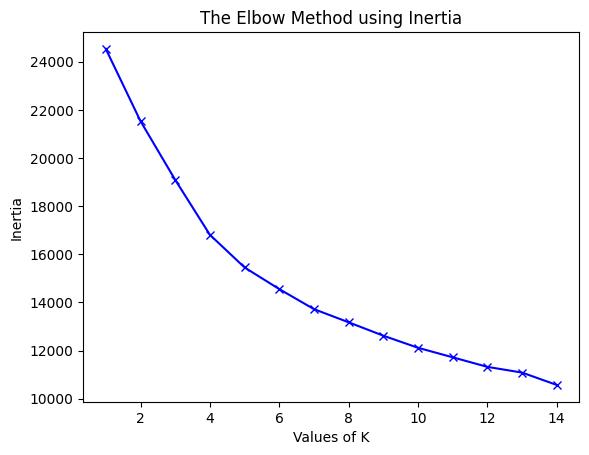

In [14]:
inertia_metric = []
range_val = range(1,15)
for i in range_val:
    kmean = KMeans(n_clusters = i)
    kmean.fit_predict(pd.DataFrame(scaled_metric))
    inertia_metric.append(kmean.inertia_)

plt.plot(range_val,inertia_metric,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

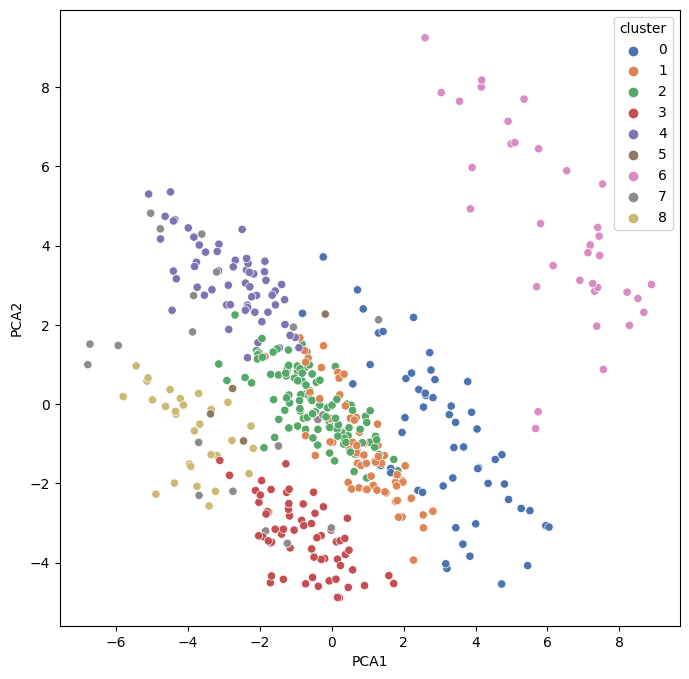

In [15]:
# Model Building using KMeans
kmeans_model_metric = KMeans(9)
kmeans_model_metric.fit_predict(scaled_metric)
pca_df_kmeans_metric= pd.concat([pca_df_metric,pd.DataFrame({'cluster':kmeans_model_metric.labels_})],axis=1)

# Visualizing the clustered dataframe
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans_metric,palette='deep')

#### Concat pitcher's assigned cluster on pitch_outcome_df

- clustered_outcome_df

<Axes: xlabel='Cluster', ylabel='count'>

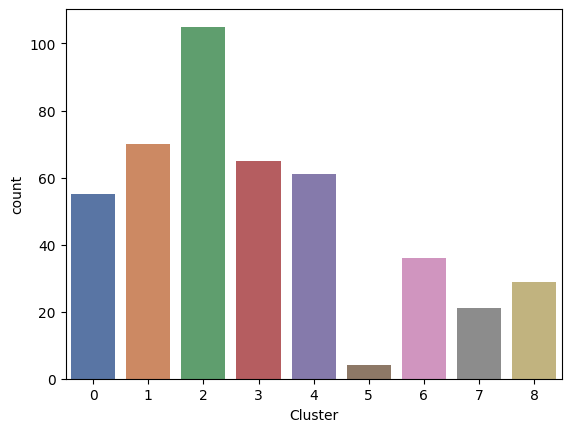

In [16]:
clustered_metric_df = pd.concat([pitch_metric_df, pd.DataFrame({'Cluster':kmeans_model_metric.labels_})],axis=1)

sns.countplot(x='Cluster', data=clustered_metric_df, palette ='deep')



### Split clustered data: Train, Test

In [18]:
X_metric = clustered_metric_df.drop(['Cluster'],axis=1)
y_metric= clustered_metric_df[['Cluster']]

X_train_metric, X_test_metric, y_train_metric, y_test_metric =train_test_split(X_metric, y_metric, test_size=0.3)


### Decision Tree Classifier for evaluation


In [23]:

kmeans_cluster_metric= DecisionTreeClassifier(criterion="entropy")

kmeans_cluster_metric.fit(X_train_metric, y_train_metric)

y_pred_metric = kmeans_cluster_metric.predict(X_test_metric)

eval_metric = classification_report(y_test_metric, y_pred_metric)

print(metrics.confusion_matrix(y_test_metric, y_pred_metric))
print(classification_report(y_test_metric, y_pred_metric))



[[13  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0]
 [ 0  0 31  0  1  0  0  0  0]
 [ 0  0  0 21  0  0  1  0  3]
 [ 0  0  1  0 12  1  0  0  0]
 [ 1  0  0  0  0  1  0  0  1]
 [ 0  0  0  0  0  0 12  0  0]
 [ 1  0  2  0  0  0  0  3  1]
 [ 0  0  0  0  0  0  0  0  7]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      1.00      1.00        21
           2       0.91      0.97      0.94        32
           3       1.00      0.84      0.91        25
           4       0.92      0.86      0.89        14
           5       0.50      0.33      0.40         3
           6       0.92      1.00      0.96        12
           7       1.00      0.43      0.60         7
           8       0.58      1.00      0.74         7

    accuracy                           0.90       134
   macro avg       0.86      0.83      0.82       134
weighted avg       0.92      0.90      0.90       134



# KMeans Clustering Model File Outputs

In [21]:
##########################################
####### Saving Simple Pitch Model ########
##########################################
import joblib
import pickle

joblib.dump(kmeans_model_metric, 'model_kmeans_pitch_metrics.pkl')


filename_metric = 'kmeans_metric.sav'
pickle.dump(kmeans_model_metric, open(filename_metric, 'wb'))

loaded_model_metric = pickle.load(open(filename_metric, 'rb'))
tested_metric = loaded_model_metric.predict(X_test_metric)




# Clustered Model To CSV File Outputs

In [26]:
##########################################
#######     Pitch Metric CSV       #######
##########################################


name_clustered_metric = clustered_metric_df
name_clustered_metric['last_name'] = df['last_name']
name_clustered_metric['first_name'] = df[' first_name']

name_clustered_metric.to_csv("Name_Clustered_Metric.csv")

